In [1]:
%matplotlib inline

import xarray as xr
import pickle
import numpy as np
import os
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy
import pandas as pd
from sklearn import linear_model
from sklearn.metrics import r2_score
import seaborn as sns
import scipy.stats
import sys

from tonic.io import read_config, read_configobj

/civil/hydro/ymao/anaconda3/envs/sm/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/civil/hydro/ymao/anaconda3/envs/sm/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/civil/hydro/ymao/anaconda3/envs/sm/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/civil/hydro/ymao/anaconda3/envs/sm/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/civil/hydro/ymao/anaconda3/envs/sm/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  retu

In [2]:
# ========================================= #
# Process command line arguments
# ========================================= #
# Load both SMAP and GLDAS, v1 and v2 results
dict_cfg = {}
for v in ['v1', 'v2']:
    dict_cfg['SMAP_{}'.format(v)] = read_configobj(
        '/civil/hydro/ymao/smap_data/scripts/cfg/20181103.SMAP_recom_qual.exclude_gpm_arctic/'
        'X_{}.linear.cfg'.format(v))
    dict_cfg['GLDAS_{}'.format(v)] = read_configobj(
        '/civil/hydro/ymao/smap_data/scripts/cfg/20181103.GLDAS_VIC.exclude_gpm_arctic/smap_freq/'
        'X_{}.linear.cfg'.format(v))
    
# Output data dir
output_dir = 'output/20181103.smap_gldas'

In [3]:
# ======================================= #
# Make output plot dir
# ======================================= #
# Output plot dir
output_plot_dir = os.path.join(output_dir, 'time_series')
if not os.path.exists(output_plot_dir):
    os.makedirs(output_plot_dir)
    
# Output data dir - for loading results
dict_output_data_dir = {}
for key in dict_cfg:
    cfg = dict_cfg[key]
    dict_output_data_dir[key] = os.path.join(
        cfg['OUTPUT']['output_dir'], 'data')

In [4]:
# ======================================= #
# Load data
# ======================================= #
print('Loading results...')

# --- Domain --- #
dict_da_domain = {}  # {SMAP/GLDAS: da}
for key in ['SMAP', 'GLDAS']:
    cfg = dict_cfg['{}_v1'.format(key)]
    dict_da_domain[key] = xr.open_dataset(
        cfg['DOMAIN']['domain_nc'])['mask']

dict_list_coef = {}
for key in dict_cfg:
    print(key)
    cfg = dict_cfg[key]
    # Extract regression information
    regression_type = cfg['REGRESSION']['regression_type']
    standardize = cfg['REGRESSION']['standardize']
    X_version = cfg['REGRESSION']['X_version']
    if regression_type == 'linear':
        pass
    elif regression_type == 'lasso' or regression_type == 'ridge':
        alpha = cfg['REGRESSION']['alpha']
    # Construct result filename
    file_basename = 'X_{}.{}.{}.{}'.format(
        X_version,
        regression_type,
        'standardize' if standardize else 'no_standardize',
        '{}.'.format(lasso_alpha) if regression_type == 'lasso' else '')
    # Determine n_coef
    if X_version == 'v1':
        n_coef = 2
    elif X_version == 'v2':
        n_coef = 3
    elif X_version == 'v3':
        n_coef = 4
    elif X_version == 'v4':
        n_coef = 3

    # --- Load results --- #
    # Coef
    list_coef = []
    for i in range(n_coef):
        da_coef = xr.open_dataset(
            os.path.join(dict_output_data_dir[key],
            '{}fitted_coef.{}.nc'.format(file_basename, i+1)))['coef']
        da_coef.load()
        da_coef.close()
        list_coef.append(da_coef)
    
    # --- Put final results into dict --- #
    dict_list_coef[key] = list_coef

Loading results...
SMAP_v2
GLDAS_v2
SMAP_v1
GLDAS_v1


In [5]:
# --- Load input SM and precipitation data --- #
dict_da_sm = {}  # {SMAP/GLDAS: da}
dict_da_prec = {}  # {SMAP/GLDAS: da}
for key in ['SMAP', 'GLDAS']:
    cfg = dict_cfg['{}_v1'.format(key)]
    # SM (instantaneous time points; SMAP or GLDAS SSM
    da_sm = xr.open_dataset(
        cfg['INPUT']['smap_nc'])['soil_moisture']
    da_sm.load()
    da_sm.close()
    # Precipitation (time-beginning timestamp); GPM or GLDAS precip
    da_prec = xr.open_dataset(
        cfg['INPUT']['gpm_nc'])['PREC']
    da_prec.load()
    da_prec.close()
    # Put in dict
    dict_da_sm[key] = da_sm
    dict_da_prec[key] = da_prec

# Investigate pixel

In [112]:
# ======================================= #
# Investigate pixel - SMAP lat lon indices
# ======================================= #
# --- Sahara --- #
# 1) with very little P; P and SM*P highly correlated
#lat_ind = 281
#lon_ind = 555
# 2)
#lat_ind = 302
#lon_ind = 479
# 3)
#lat_ind = 296
#lon_ind = 477
# 4)
#lat_ind = 285
#lon_ind = 558
# 5)
#lat_ind = 266
#lon_ind = 573
# --- Southern Africa --- #
#lat_ind = 99
#lon_ind = 540
# --- Xinjiang --- #
# 1)
#lat_ind = 328
#lon_ind = 710
# 2) Similar SMAP and GLDAS
lat_ind = 332
lon_ind = 703
# 3)
#lat_ind = 329
#lon_ind = 698
# --- Tibet --- #
#lat_ind = 312
#lon_ind = 710
# --- India --- #
# 1) GLDAS gamma3 = 0
#lat_ind = 265
#lon_ind = 695
# 2) GLDAS gamma3 ~= SMAP
#lat_ind = 280
#lon_ind = 708
# --- Very north boreal forest --- #
# 1) zero beta2
#lat_ind = 392
#lon_ind = 825
# 2)
#lat_ind = 387
#lon_ind = 848
# 3)
#lat_ind = 390
#lon_ind = 735
# 4)
#lat_ind = 386
#lon_ind = 111
# --- Western US --- #
# 1)
#lat_ind = 336
#lon_ind = 167
# 2)
#lat_ind = 327
#lon_ind = 173
# --- Australia --- #
# 1)
#lat_ind = 118
#lon_ind = 841
# 2)
#lat_ind = 123
#lon_ind = 850
# --- South America --- #
# 1) North end
#lat_ind = 222
#lon_ind = 295
# 1) North end
#lat_ind = 226
#lon_ind = 298

39.58491897583008 82.71784210205078
SMAP: 332 703
GLDAS: 99 262


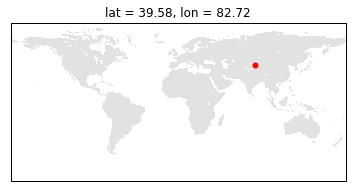

In [113]:
# --- Determine the closest GLDAS grid --- #
lat_smap = float(dict_da_domain['SMAP']['lat'][lat_ind].values)
lon_smap = float(dict_da_domain['SMAP']['lon'][lon_ind].values)
lat_gldas, lon_gldas = find_1deg_grid_gldas(
    lat_smap, lon_smap)
lat_ind_gldas = np.where(
    dict_da_domain['GLDAS']['lat'].values==lat_gldas)[0][0]
lon_ind_gldas = np.where(
    dict_da_domain['GLDAS']['lon'].values==lon_gldas)[0][0]
# Put lat lon into dict
dict_lat_ind = {'SMAP': lat_ind,
                'GLDAS': lat_ind_gldas}
dict_lon_ind = {'SMAP': lon_ind,
                'GLDAS': lon_ind_gldas}

print(lat_smap, lon_smap)
print('SMAP:', lat_ind, lon_ind)
print('GLDAS:', lat_ind_gldas, lon_ind_gldas)

# Plot location
fig = plt.figure(figsize=(6, 4))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -85, 85], ccrs.Geodetic())
#gl = add_gridlines(ax, alpha=0)
ax.add_feature(cartopy.feature.LAND,
               facecolor=[1, 1, 1],
               edgecolor=[0.5, 0.5, 0.5], linewidth=0.3)
cs = dict_da_domain['SMAP'].plot.pcolormesh(
    'lon', 'lat', ax=ax,
    add_colorbar=False,
    add_labels=False,
    cmap='Greys',
    vmin=0, vmax=5,
    transform=ccrs.PlateCarree())
plt.plot([lon_smap], [lat_smap], 'r.', markersize=10,
         transform=ccrs.PlateCarree())
plt.title('lat = {:.2f}, lon = {:.2f}'.format(lat_smap, lon_smap))
# Save fig
fig.savefig(
    os.path.join(
        output_plot_dir,
        'smap_{}_{}.gldas_{}_{}.location.png'.format(
            dict_lat_ind['SMAP'], dict_lon_ind['SMAP'],
            dict_lat_ind['GLDAS'], dict_lon_ind['GLDAS'])),
    format='png', bbox_inches='tight', pad_inches=0)

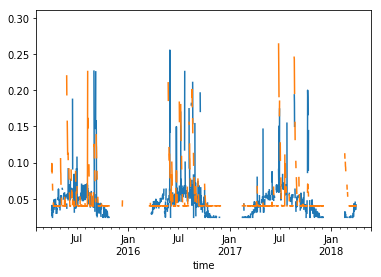

In [114]:
# --- Extract time series --- #
dict_ts_sm = {}  # {SMAP/GLDAS: ts}
dict_ts_prec = {}  # {SMAP/GLDAS: ts}
dict_df = {}  # {SMAP/GLDAS: ts}
for key in ['SMAP', 'GLDAS']:
    # Extract time series
    ts_sm = dict_da_sm[key][
        :, dict_lat_ind[key], dict_lon_ind[key]].to_series()
    ts_prec = dict_da_prec[key][
        :, dict_lat_ind[key], dict_lon_ind[key]].to_series()
    # Put into dict
    dict_ts_sm[key] = ts_sm
    dict_ts_prec[key] = ts_prec
    # Put SMAP and prec into a df
    ts_prec = ts_prec.truncate(before=ts_sm.index[0],
                               after=ts_sm.index[-1])
    ts_sm = ts_sm.truncate(before=ts_prec.index[0],
                               after=ts_prec.index[-1])
    df = pd.concat([ts_sm, ts_prec], axis=1,
                   keys=['sm', 'prec'])
    dict_df[key] = df

    ts_sm.plot()

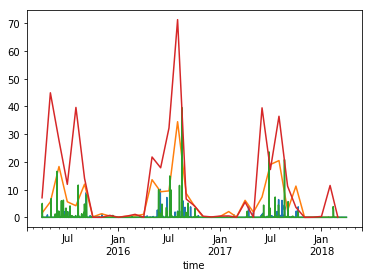

In [115]:
for key in ['SMAP', 'GLDAS']:
    ts_prec = dict_ts_prec[key]
    ts_prec.plot()
    ts_prec.resample('1M').sum().plot()

In [116]:
# --- Extract fitted coefficients for this pixel --- #
dict_coef_pixel = {}  # keys: SMAP/GLDAS_v1/v2
for key in dict_list_coef:
    list_coef_pixel = []
    # Extract n_coef
    X_version = key[-2:]
    if X_version == 'v1':
        n_coef = 2
    elif X_version == 'v2':
        n_coef = 3
    # Extract SMAP/GLDAS
    data_source = key.split('_')[0]
    # Extract fitted coef
    lati = dict_lat_ind[data_source]
    loni = dict_lon_ind[data_source]
    for i in range(n_coef):
        list_coef_pixel.append(
            float(dict_list_coef[key][i][lati, loni].values))
    coef_pixel = np.asarray(list_coef_pixel).reshape([n_coef, 1])
    dict_coef_pixel[key] = coef_pixel

In [117]:
dict_coef_pixel

{'GLDAS_v1': array([[-0.00633246],
        [ 0.00683269]]), 'GLDAS_v2': array([[-0.0056466 ],
        [ 0.0114525 ],
        [-0.04108261]]), 'SMAP_v1': array([[-0.01130794],
        [ 0.01598004]]), 'SMAP_v2': array([[-0.01056436],
        [ 0.02662563],
        [-0.1225372 ]])}

In [118]:
# --- Back-calculate SM time series using fitted coefficients --- #
dict_ts_sm_pred_12H = {}
for key in dict_coef_pixel:
    # Extract SMAP/GLDAS
    data_source = key.split('_')[0]
    # Extract ts_prec
    ts_prec = dict_ts_prec[data_source]
    # Determine initial SM by average ts_sm
    sm_init = dict_ts_sm[data_source].mean()
    # Back-calculate
    ts_sm_pred_12H = predict_soil_moisture_ts(
        dict_coef_pixel[key],
        key[-2:],
        pd.date_range(
            ts_prec.index[0],
            ts_prec.index[-1],
            freq='12H'),
        ts_prec, sm_init)
    dict_ts_sm_pred_12H[key] = ts_sm_pred_12H

## Plot time series

/civil/hydro/ymao/anaconda3/envs/sm/lib/python3.5/site-packages/ipykernel_launcher.py:46: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()


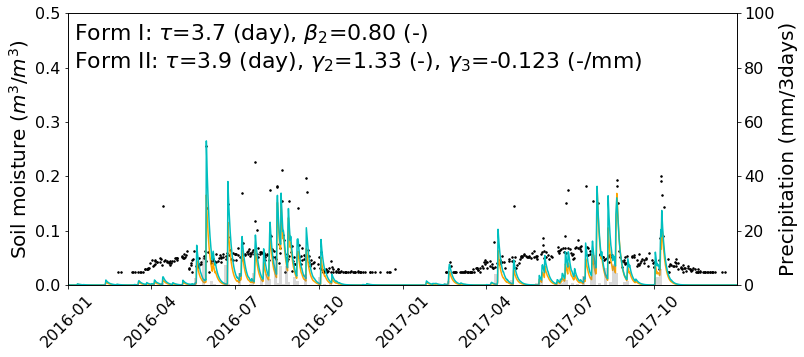

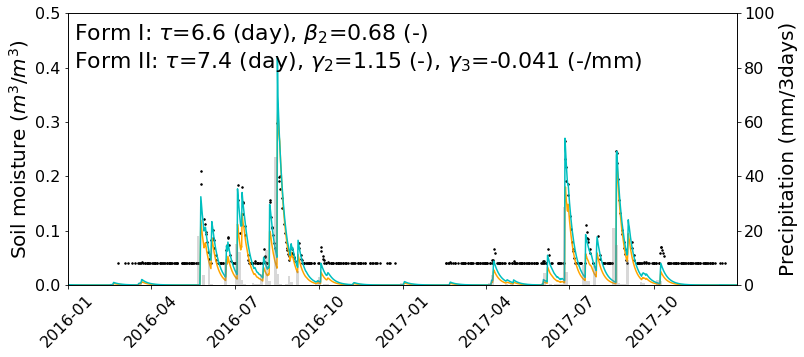

In [119]:
# Soil depth [mm]
soil_depth = {'SMAP': 50,
              'GLDAS': 100}
dict_color = {'v1': 'orange',
              'v2': 'c'}

for key in ['SMAP', 'GLDAS']:
    fig = plt.figure(figsize=(12, 5))
    # --- Extract ts --- #
    ts_sm = dict_ts_sm[key]
    ts_prec = dict_ts_prec[key]
    # --- Plot SM time series --- #
    ax1 = plt.axes()
    # SMAP/GLDAS
    ax1.plot(ts_sm.index, ts_sm.values,
             color='k', marker='.', linestyle='',
             markersize=3)
    # Back-calculated from the two versions
    dict_version_name = {'v1': 'Form I',
                         'v2': 'Form II'}
    for v in ['v1', 'v2']:
        # Construct coefficient label
        if v == 'v1':
            coef_label = r'$\tau$={:.1f} (day), $\beta_2$={:.2f} (-)'.format(
                - 1 / (dict_coef_pixel['{}_{}'.format(key, v)][0][0] * 24),
                dict_coef_pixel['{}_{}'.format(key, v)][1][0] * soil_depth[key])
        elif v == 'v2':
            coef_label = r'$\tau$={:.1f} (day), $\gamma_2$={:.2f} (-), $\gamma_3$={:.3f} (-/mm)'.format(
                - 1 / (dict_coef_pixel['{}_{}'.format(key, v)][0][0] * 24),
                dict_coef_pixel['{}_{}'.format(key, v)][1][0] * soil_depth[key],
                dict_coef_pixel['{}_{}'.format(key, v)][2][0])
        ts = dict_ts_sm_pred_12H['{}_{}'.format(key, v)]
        ax1.plot(ts.index, ts.values,
                 color=dict_color[v], linestyle='-')
        plt.text(
            0.01, 0.9 if v == 'v1' else 0.8,
            r'{}: {}'.format(dict_version_name[v], coef_label),
            horizontalalignment='left',
            transform=ax1.transAxes,
            fontsize=22)
    plt.ylabel('Soil moisture ($m^3/m^3$)', fontsize=20)
    ### Adjust for different pixels ###
    plt.ylim([0, 0.5])
    # --- Precipitation input --- #
    ax2 = ax1.twinx()
    ts_prec_to_plot = ts_prec.resample('3D', how='sum')
    ax2.bar(ts_prec_to_plot.index, ts_prec_to_plot,
            color='gray', width=3, alpha=0.3)
    ### Adjust for different pixels ###
    plt.ylim([0, 100])
    plt.ylabel('Precipitation (mm/3days)', fontsize=20)
    
    # --- Adjust ticks/labels --- #
    plt.xlim(['20160101', '20171231'])
    ax1.tick_params(labelsize=16) 
    ax2.tick_params(labelsize=16)
    ax1.tick_params(axis='x', labelrotation=45)
    
    # --- Save fig --- #
    fig.savefig(
        os.path.join(
            output_plot_dir,
            'smap_{}_{}.gldas_{}_{}.ts_{}.png'.format(
                dict_lat_ind['SMAP'], dict_lon_ind['SMAP'],
                dict_lat_ind['GLDAS'], dict_lon_ind['GLDAS'],
                key)),
    format='png', dpi=150,
    bbox_inches='tight', pad_inches=0)

In [120]:
dict_coef_pixel

{'GLDAS_v1': array([[-0.00633246],
        [ 0.00683269]]), 'GLDAS_v2': array([[-0.0056466 ],
        [ 0.0114525 ],
        [-0.04108261]]), 'SMAP_v1': array([[-0.01130794],
        [ 0.01598004]]), 'SMAP_v2': array([[-0.01056436],
        [ 0.02662563],
        [-0.1225372 ]])}

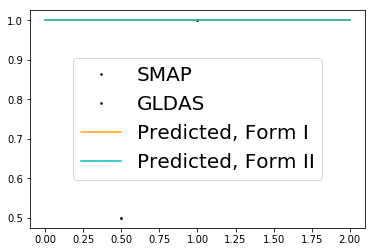

In [84]:
# --- Plot for legend --- #
fig = plt.figure()
for key in ['SMAP', 'GLDAS']:
    plt.plot([0.5, 1], [0.5, 1],
             color='k', marker='.', linestyle='',
             markersize=3,
             label=key)
for v in ['v1', 'v2']:
    plt.plot([0, 2], [1, 1],
             color=dict_color[v], linestyle='-',
             label='Predicted, Form I' if v == 'v1'
                   else 'Predicted, Form II')
plt.legend(fontsize=20, loc='center')
# --- Save fig --- #
fig.savefig(
    os.path.join(
        output_plot_dir,
        'ts_legend.png'),
    format='png', dpi=150,
    bbox_inches='tight', pad_inches=0)

# Functions

In [8]:
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

In [9]:
def predict_soil_moisture_ts(coef, X_version, times, ts_prec, sm_init):
    ''' Back-calculate SM time series from fitted coef
    
    Parameters
    ----------
    coef: <np.array>
        Fitted coefficients. Currently assume X_version v2 with:
        coef1 [hour-1] * SM [mm/mm]
        coef2 [mm-1] * P/dt
        coef3 [mm-1] * P/dt * SM
        So dim: [3]
    X_version: <str>
        v1 or v2
    times: <pd.datatime>
        A list of time points to predict SM
    ts_prec: <pd.Series>
        Precipitation input
        Must have corresponding index with times;
        Time-beginning timestamps
    sm_init: <float>
        Initial SM [mm/mm]
    '''

    n = len(times)  # Number of data points
    sm_pred = np.zeros(n)
    # Initialize sm_pred [mm/mm]
    sm_pred[0] = sm_init
    for i in range(1, n):
        time_last = times[i-1]
        time_current = times[i]
        sm_last = sm_pred[i-1]
        dt = (time_current - time_last).days * 24 + \
            (time_current - time_last).seconds / 3600  # [hour]
        prec = ts_prec.iloc[
            ts_prec.index.get_loc(time_last):\
            ts_prec.index.get_loc(time_current)].sum() \
               / dt  # [mm/hour]
        if X_version == 'v1':
            Y_pred_current = \
                coef[0] * sm_last \
                + coef[1] * prec
        elif X_version == 'v2':
            Y_pred_current = \
                coef[0] * sm_last \
                + coef[1] * prec \
                + coef[2] * sm_last * prec
        sm_pred[i] = sm_last + Y_pred_current * dt
    # Put SM results in ts
    ts_sm_pred = pd.Series(sm_pred, index=times)
    
    return ts_sm_pred

In [10]:
def find_1deg_grid_gldas(lat, lon):
    ''' Find the 1deg grid cell that a (lat, lon) point falls in
        according to GLDAS grid

    Input arguments: lat, lon (can be single number or np array)
    Return: lat_grid, lon_grid
    Module requred: import numpy as np
    '''
    lat_grid = np.around(lat-0.5) + 0.5
    lon_grid = np.around(lon-0.5) + 0.5
    return lat_grid, lon_grid

In [11]:
def add_gridlines(axis,
                  xlocs=[-150, -100, -50, 0,
                         50, 100, 150],
                  ylocs=[-80, -60, -40, -20, 0, 20, 40, 60, 80],
                  alpha=1):
    gl = axis.gridlines(draw_labels=True, xlocs=xlocs, ylocs=ylocs,
                        alpha=alpha)
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    return gl